In [1]:
import os
import subprocess as sp
from time import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from models import *
from utils import *

## Notes
- Every generator and critic at every scale has the same architecture, with 5 Conv(3x3)-BN-LReLU layers.
- The patch size is given as 11x11, which comes from the receptive field of the 5 layer deep network.
- How the number of kernels change is not exactly clear, paper says "start with 32, double once every 4 scales"
- It is not clear whether the conv layers use padding (zero, reflect?) to preserve size or not. We assume for now that the generators do preserve the size, but it does not seem necessary for the critics.
- How the downsampling is done is not clear from the paper. We assume bicubic interpolation.
- For the coarsest scale, authors say that "the effective receptive field at this level is typically∼1/2of the image’s height". ~~We assume that this means the input size at the coarsest scale is somewhere between 20 and 25 pixels.~~ The authors later state that they use 25 px for the coarsest and 250 pixels for the finest scale along with a rescaling ratio of 4/3. 
- Lots of training details are given in the supplementary material.
- It is not clear 

In [2]:
# image to train on
IMG_PATH = 'images/mountains.jpg'

# training hyperparameters, 
# as given in the paper
GEN_LEARNING_RATE = 0.0005
CRIT_LEARNING_RATE = 0.0005
BETA_1 = 0.5
BETA_2 = 0.999
NUM_ITERS = 2000
LR_DROP_STEP = 1600
LR_DROP_MULT = 0.1
GEN_STEP_PER_ITER = 3
CRIT_STEP_PER_ITER = 3
REC_ALPHA = 10.0
GP_WEIGHT = 0.1

# architecture details
NUM_SCALES = 8
SCALING_FACTOR = 4/3
KERNEL_SIZE = 3
NUM_BLOCKS = 5
INITIAL_KERNEL_COUNT = 32
INCREASE_KERNEL_COUNT_EVERY = 4 # SCALES
NOISE_BASE_STD = 0.1
FIRST_SCALE_NOISE_STD = 1.0
MAX_INPUT_SIZE = 250
DOWNSAMPLING_MODE = 'bicubic'  # mode used when downscaling the original input
UPSAMPLING_MODE = 'nearest'  # mode used when upscaling during training

# extra settings
PRINT_EVERY = 50
DEVICE = 'cuda'
SEED = 796
SAVE_DIR = 'models'

In [3]:
# closures for easy use depending on settings, so that
# we can skip providing every single argument at each iteration
def make_generator(kernel_count, noise_std):
  sgnet = SGNet(NUM_BLOCKS, kernel_count, KERNEL_SIZE, final_activation=nn.Tanh(), output_channels=3).to(DEVICE)
  return SGGen(sgnet, noise_std)
  
def make_critic(kernel_count):
  return SGNet(NUM_BLOCKS, kernel_count, KERNEL_SIZE, final_activation=None, output_channels=1).to(DEVICE)

def make_optimizer_and_scheduler(net, net_learning_rate):
  optimizer = torch.optim.Adam(net.parameters(), net_learning_rate, (BETA_1, BETA_2))
  sched = torch.optim.lr_scheduler.StepLR(optimizer, LR_DROP_STEP, LR_DROP_MULT)
  return optimizer, sched

Resized image from 366x585 to 156x250
Input image:


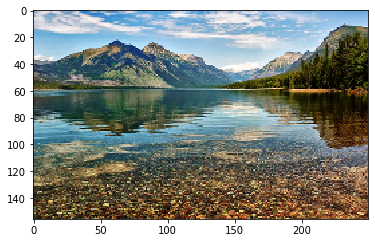

In [4]:
# load the image along with its downsampled versions and their exact sizes
scaled_origs, exact_sizes = load_with_reverse_pyramid(IMG_PATH, MAX_INPUT_SIZE, 1/SCALING_FACTOR, NUM_SCALES, 
                                                      mode=DOWNSAMPLING_MODE, device=DEVICE, verbose=True)
  
original_image = scaled_origs[-1]
print('Input image:')
plt.imshow(normed_tensor_to_np_image(original_image))

In [ ]:
# seed stuff
seed_rngs(SEED)

# create the scaled images
coarsest_exact_size = exact_sizes[0]

# initialize the constant noise used in reconstruction
z_rec_coarsest = FIRST_SCALE_NOISE_STD * torch.randn_like(scaled_origs[0], device=DEVICE)
z_rec = [z_rec_coarsest] # a zero tensor is appended after each scale

# constant zero input for the coarsest scale during training
coarsest_zero_input = torch.zeros_like(z_rec_coarsest)


In [ ]:
# loop values
kernel_count = INITIAL_KERNEL_COUNT
generators, critics = [], []
gen_losses, crit_losses = [], []
for scale_index in range(NUM_SCALES):
  print('****************************\nScale {}'.format(scale_index))

  # get the original image at the current scale
  scale_orig_img = scaled_origs[scale_index]

  # things to be done after the first scale
  if scale_index > 0:
    # use RMSE to determine the standard deviation of the input noise
    with torch.no_grad():
      reconstruction = generator(z_rec)  # specific reconstruction noise
    scaled_reconstruction, _ = exact_interpolate(reconstruction, SCALING_FACTOR, exact_sizes[scale_index-1], UPSAMPLING_MODE)
    rmse = torch.sqrt(F.mse_loss(scaled_reconstruction, scale_orig_img))
    print('RMSE: {:.2f}'.format(rmse))
    # if the scale matches, increase kernel count
    if scale_index % INCREASE_KERNEL_COUNT_EVERY == 0:
      kernel_count *= 2
    # add a zero tensor to the reconstruction noise list
    # since it is defined as [z*, 0, 0, 0...] for some z*
    z_rec.append(torch.zeros_like(scale_orig_img))
      
  # create the noise sampler based on the RMSE
  # the first scale's stdev is different due to the zero input,
  # the noise has to be much stronger than in the upper layers
  scale_noise_std = FIRST_SCALE_NOISE_STD if scale_index == 0 else rmse * NOISE_BASE_STD

  ## initialize the generator
  # create a generator for this specific scale and initialize it
  scale_generator = make_generator(kernel_count, scale_noise_std)
  # copy weights from previous if possible, and add to the list
  initialize_net(scale_generator, generators)
  
  # create a single generator view from the stack of generators
  generic_generator = MultiScaleSGGenView(generators, SCALING_FACTOR, UPSAMPLING_MODE)
  # fix the input parameters for easier forward calls
  generator = FixedInputSGGenView(generic_generator, coarsest_zero_input, coarsest_exact_size)
  
  ## initialize the critic (discriminator)
  critic = make_critic(kernel_count)
  initialize_net(critic, critics)

  # create the optimizers and schedulers
  gen_optimizer, gen_sched = make_optimizer_and_scheduler(generator, GEN_LEARNING_RATE)
  crit_optimizer, crit_sched = make_optimizer_and_scheduler(critic, CRIT_LEARNING_RATE)

  # print norms to ensure correct operation
  gen_norms = ['G{}: {:.3f}'.format(i, sum_param_norms(g)) for i, g in enumerate(generators)]
  crit_norms = ['C{}: {:.3f}'.format(i, sum_param_norms(c)) for i, c in enumerate(critics)]
  print('Generator norms: ' + ', '.join(gen_norms))
  print('Critic norms: ' + ', '.join(crit_norms))
  
  # perform training
  for step in range(NUM_ITERS):

    for _ in range(CRIT_STEP_PER_ITER):
      crit_optimizer.zero_grad()
      
      # the model handles noise sampling on its own
      fake_img = generator()
      
      # gradient & adversarial loss
      grad_loss = gradient_penalty(critic, fake_img, scale_orig_img)
      fake_loss = critic(fake_img).mean()
      real_loss = -critic(scale_orig_img).mean()
      crit_loss =  fake_loss + real_loss + GP_WEIGHT * grad_loss
      
      optimization_step(crit_loss, crit_optimizer, crit_sched, crit_losses)

    # zero gradient before beginning because
    # generator was used in the crit. training
    for _ in range(GEN_STEP_PER_ITER):
      gen_optimizer.zero_grad()

      fake_img = generator()

      # adversarial & reconstruction loss
      adv_loss = -critic(fake_img).mean()
      rec_img = generator(z_rec)
      rec_loss = F.mse_loss(scale_orig_img, rec_img)
      gen_loss = adv_loss + REC_ALPHA * rec_loss
      
      optimization_step(gen_loss, gen_optimizer, gen_sched, gen_losses)

    if step % PRINT_EVERY == 0:
      # print some details
      print('Step: {}'.format(step))
      print('Generator adv: {:.3f}, rec: {:.3f}'.format(adv_loss.item(), rec_loss.item()))
      print('Critic fake: {:.3f} real: {:.3f} grad: {:.3f}'.format(fake_loss.item(), real_loss.item(), grad_loss.item()))
      if step != 0:
        elapsed = time() - last_print
        print('Steps per second: {:.2f}'.format(PRINT_EVERY / elapsed))
        
      # example noise sample at highest scale
      with torch.no_grad():
        fake_example = generator()
      plt.imshow(normed_tensor_to_np_image(fake_example))
      plt.show()
      last_print = time()

  # show the reconstruction at the end of training
  print('Reconstruction vs Original:')
  with torch.no_grad():
    final_rec = generator(z_rec)
  plt.subplot(121)
  plt.imshow(normed_tensor_to_np_image(final_rec))
  plt.subplot(122)
  plt.imshow(normed_tensor_to_np_image(scale_orig_img))
  plt.show()

# save the model when done
save_path = get_model_path(SAVE_DIR, IMG_PATH)
save_model(save_path, generators, critics, SCALING_FACTOR, UPSAMPLING_MODE)

In [ ]:
# can modify IMG_PATH here if necessary
# IMG_PATH = 'images/birds.png'

IMG_PATH = 'images/birds.png'
NUM_SAMPLES = 25
INPUT_SCALE = 2
SEED = 797 # different from the first one

# about the INPUT_SCALE:
# 0 is coarsest, 1 one upper etc.
# when the input_scale > 0, the
# scaled original image is provided as
# input to the input_scale and lower
# scales are ignored entirely

# re-seed for reproducibility
seed_rngs(SEED)

# load the image pyramid
scaled_origs, exact_sizes = load_with_reverse_pyramid(IMG_PATH, MAX_INPUT_SIZE, 1/SCALING_FACTOR, NUM_SCALES, 
                                                      mode=DOWNSAMPLING_MODE, device=DEVICE, verbose=True)

# load the saved model, critics are not necessary
model_path = get_model_path(SAVE_DIR, IMG_PATH)
generators, _, scaling_factor, scaling_mode = load_model(model_path)
generic_gen = MultiScaleSGGenView(generators[INPUT_SCALE:], scaling_factor, scaling_mode)

# fix the input of the model, by default the downsampled original image
gen_input = scaled_origs[INPUT_SCALE]
gen_size = exact_sizes[INPUT_SCALE]
if INPUT_SCALE == 0: # nothing at the lowest scale
  gen_input = torch.zeros_like(gen_input)
gen = FixedInputSGGenView(generic_gen, gen_input, gen_size)

# generate samples
print('Original: ')
plt.imshow(normed_tensor_to_np_image(scaled_origs[-1]))
for i in range(NUM_SAMPLES):
  random_sample = gen()
  print('Sample {}: '.format(i))
  plt.imshow(normed_tensor_to_np_image(random_sample))
  plt.show()
  